In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/energydata_complete.csv")

In [4]:
ts = df["Appliances"]

In [5]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [6]:
dates = pd.to_datetime(df.date)

In [7]:
series = np.asarray(ts.values)

In [8]:
time = np.arange(series.shape[0])

In [9]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [10]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 20000):
    dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size = shuffle_buffer) #IID gd works best #buffersize must be greater or equal to the number of examples
    dataset = dataset.batch(batch_size).prefetch(1) # you probably will want bigger batchs like 32 / 64
    return dataset

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [13]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True) # we shift cause one start where other ends
    ds = ds.flat_map(lambda window: window.batch(window_size + 1)) # we dont shuffle cause we need in order
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [14]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [15]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## CNN

* In 1D-Convolutional Layer we slide through only one dimension. The layer compute a weighted sum of the steps + a bias term and applies an activation function (usually relu).
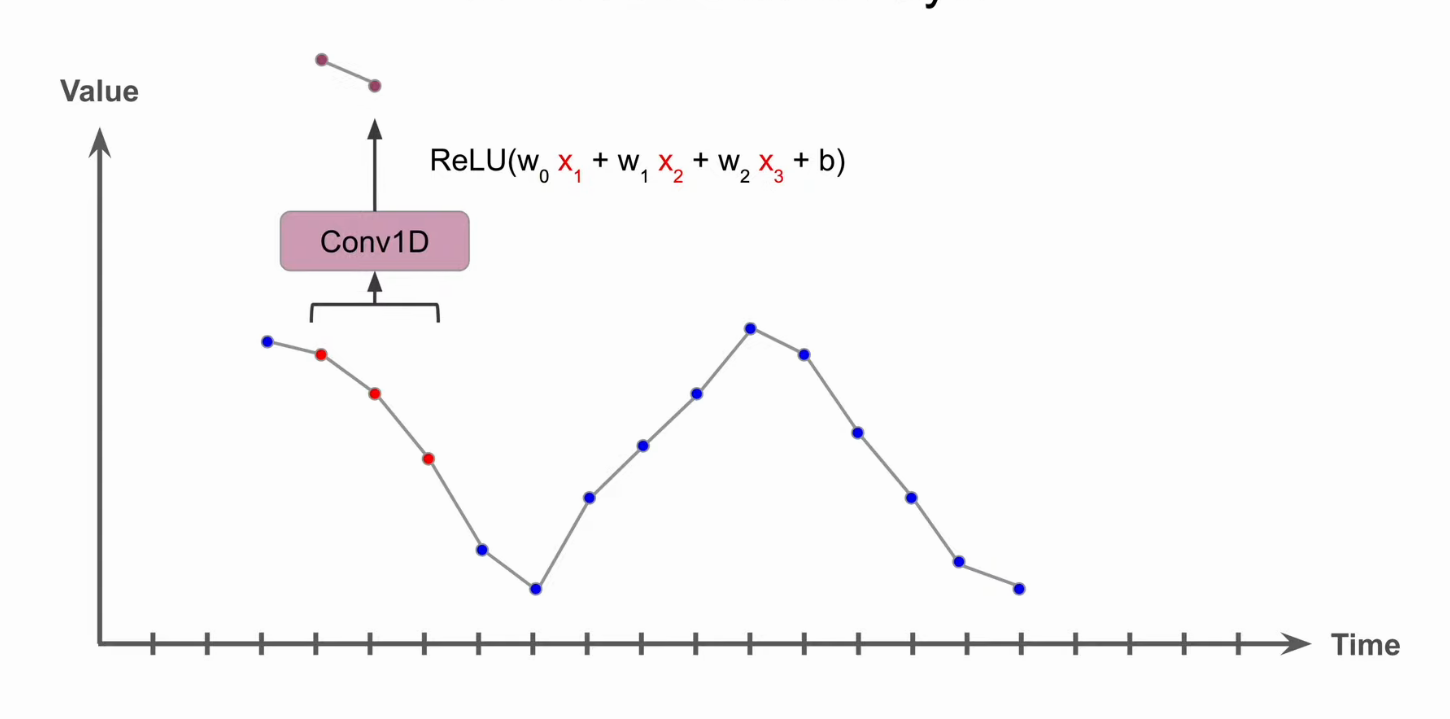

### Padding
* valid
* same -> 0's in left and right
* causal -> 0's only in the left side

### Stride
* May help with long term patterns as it shorten the sequence

## LSTM with 1D-Convolutional layers

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[None,1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = keras.optimizers.Adam()
model.compile(loss=keras.metrics.mean_squared_error,
             optimizer=optimizer,
             metrics=["mae", "mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
124/124 [==============================] - 3s 23ms/step - loss: 31814.4063 - mae: 144.1981 - mse: 31895.0605
Epoch 2/100
124/124 [==============================] - 2s 13ms/step - loss: 31824.0271 - mae: 144.1465 - mse: 31880.1074
Epoch 3/100
124/124 [==============================] - 2s 13ms/step - loss: 31882.1033 - mae: 144.0886 - mse: 31863.3164
Epoch 4/100
124/124 [==============================] - 2s 12ms/step - loss: 31832.1312 - mae: 144.0256 - mse: 31845.0742
Epoch 5/100
124/124 [==============================] - 2s 13ms/step - loss: 31860.0061 - mae: 143.9586 - mse: 31825.6582
Epoch 6/100
124/124 [==============================] - 2s 13ms/step - loss: 31702.2558 - mae: 143.8867 - mse: 31804.8301
Epoch 7/100
124/124 [==============================] - 2s 12ms/step - loss: 31731.4457 - mae: 143.8069 - mse: 31781.7168
Epoch 8/100
124/124 [==============================] - 1s 12ms/step - loss: 31726.7956 - mae: 143.7149 - mse: 31755.0996
Epoch 9/100
124/124 [===========

124/124 [==============================] - 2s 13ms/step - loss: 7008.2222 - mae: 42.6663 - mse: 7024.7603
Epoch 69/100
124/124 [==============================] - 2s 13ms/step - loss: 6706.3995 - mae: 41.7606 - mse: 6733.7109
Epoch 70/100
124/124 [==============================] - 2s 13ms/step - loss: 6507.4436 - mae: 40.9726 - mse: 6502.9058
Epoch 71/100
124/124 [==============================] - 2s 12ms/step - loss: 6262.6730 - mae: 40.2397 - mse: 6282.1289
Epoch 72/100
124/124 [==============================] - 2s 13ms/step - loss: 6021.4578 - mae: 39.5021 - mse: 6040.3286
Epoch 73/100
124/124 [==============================] - 2s 13ms/step - loss: 5792.6274 - mae: 38.8163 - mse: 5808.8550
Epoch 74/100
124/124 [==============================] - 2s 12ms/step - loss: 5593.6377 - mae: 38.3220 - mse: 5612.1626
Epoch 75/100
124/124 [==============================] - 2s 12ms/step - loss: 5439.8392 - mae: 37.7323 - mse: 5449.9717
Epoch 76/100
124/124 [==============================] - 2s 12

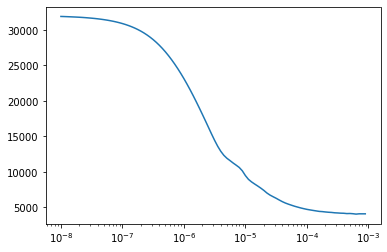

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [41]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[None,1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.Adam(learning_rate=7e-3)
model.compile(loss=keras.metrics.mean_squared_error,
             optimizer=optimizer,
             metrics=["mae", "mse"])

model_checkpoint = keras.callbacks.ModelCheckpoint("CNN1_check.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[model_checkpoint, early_stopping])

Epoch 1/500
124/124 [==============================] - 3s 27ms/step - loss: 6505.2058 - mae: 42.4462 - mse: 6535.3682 - val_loss: 3954.7261 - val_mae: 30.1889 - val_mse: 3939.3245
Epoch 2/500
124/124 [==============================] - 2s 16ms/step - loss: 4543.5788 - mae: 32.3163 - mse: 4556.9868 - val_loss: 3638.7737 - val_mae: 25.9735 - val_mse: 3615.2375
Epoch 3/500
124/124 [==============================] - 2s 16ms/step - loss: 4459.7184 - mae: 31.7506 - mse: 4463.2178 - val_loss: 3918.6636 - val_mae: 30.6872 - val_mse: 3898.8579
Epoch 4/500
124/124 [==============================] - 2s 16ms/step - loss: 4274.1383 - mae: 30.7720 - mse: 4280.8696 - val_loss: 3620.9181 - val_mae: 25.5553 - val_mse: 3601.7493
Epoch 5/500
124/124 [==============================] - 2s 15ms/step - loss: 4316.6134 - mae: 31.0569 - mse: 4317.7505 - val_loss: 3554.0647 - val_mae: 25.5692 - val_mse: 3546.2329
Epoch 6/500
124/124 [==============================] - 2s 15ms/step - loss: 4383.4171 - mae: 31.6472

In [46]:
model = keras.models.load_model("CNN1_check.h5")

In [47]:
cnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

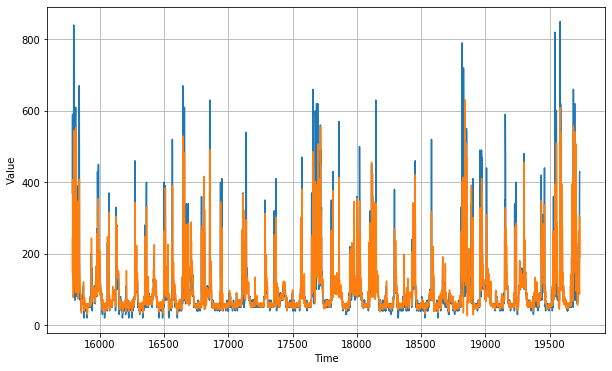

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [49]:
keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

3638.389

### WaveNet
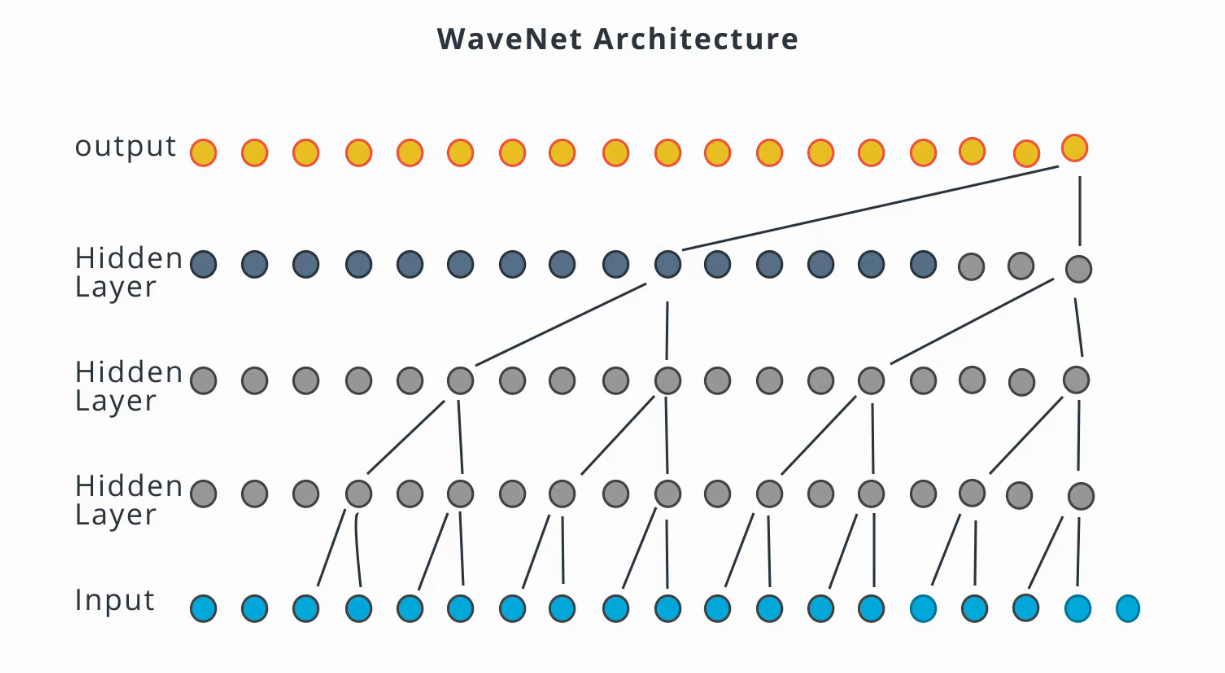
* Dilation rate doubles at every layer
* The lower layers learn short term patterns while the higher learn long-term ones

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = keras.optimizers.Adam()
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=optimizer,
              metrics=["mae","mse"])
history = model.fit(train_set, epochs=160, callbacks=[lr_schedule])

Epoch 1/160
123/123 [==============================] - 3s 23ms/step - loss: 21271.0214 - mae: 99.8511 - mse: 21275.4277
Epoch 2/160
123/123 [==============================] - 2s 15ms/step - loss: 21272.4674 - mae: 99.8490 - mse: 21274.8574
Epoch 3/160
123/123 [==============================] - 2s 15ms/step - loss: 21270.7717 - mae: 99.8467 - mse: 21274.2402
Epoch 4/160
123/123 [==============================] - 2s 16ms/step - loss: 21272.5452 - mae: 99.8443 - mse: 21273.5527
Epoch 5/160
123/123 [==============================] - 2s 15ms/step - loss: 21271.8034 - mae: 99.8417 - mse: 21272.8320
Epoch 6/160
123/123 [==============================] - 2s 14ms/step - loss: 21267.2552 - mae: 99.8390 - mse: 21272.0566
Epoch 7/160
123/123 [==============================] - 2s 14ms/step - loss: 21263.5925 - mae: 99.8359 - mse: 21271.2051
Epoch 8/160
123/123 [==============================] - 2s 14ms/step - loss: 21270.7267 - mae: 99.8324 - mse: 21270.2285
Epoch 9/160
123/123 [===================

123/123 [==============================] - 2s 16ms/step - loss: 6736.5387 - mae: 40.1528 - mse: 6737.5962
Epoch 69/160
123/123 [==============================] - 2s 15ms/step - loss: 6199.8413 - mae: 37.8655 - mse: 6202.1064
Epoch 70/160
123/123 [==============================] - 2s 16ms/step - loss: 5752.5239 - mae: 35.8503 - mse: 5753.0151
Epoch 71/160
123/123 [==============================] - 2s 16ms/step - loss: 5387.9799 - mae: 34.2457 - mse: 5389.3506
Epoch 72/160
123/123 [==============================] - 2s 16ms/step - loss: 5094.8554 - mae: 32.9758 - mse: 5095.8052
Epoch 73/160
123/123 [==============================] - 2s 15ms/step - loss: 4876.0947 - mae: 32.0637 - mse: 4878.0308
Epoch 74/160
123/123 [==============================] - 2s 15ms/step - loss: 4740.8044 - mae: 31.4842 - mse: 4742.2886
Epoch 75/160
123/123 [==============================] - 2s 15ms/step - loss: 4665.6057 - mae: 31.1863 - mse: 4666.2358
Epoch 76/160
123/123 [==============================] - 2s 16

123/123 [==============================] - 2s 16ms/step - loss: 5087.5752 - mae: 35.1149 - mse: 5088.7603
Epoch 137/160
123/123 [==============================] - 2s 16ms/step - loss: 4474.4044 - mae: 30.9162 - mse: 4475.8682
Epoch 138/160
123/123 [==============================] - 2s 16ms/step - loss: 4431.2851 - mae: 30.9690 - mse: 4431.9004
Epoch 139/160
123/123 [==============================] - 2s 16ms/step - loss: 4367.5589 - mae: 30.8600 - mse: 4368.6782
Epoch 140/160
123/123 [==============================] - 2s 16ms/step - loss: 5182.6148 - mae: 34.7690 - mse: 5185.1221
Epoch 141/160
123/123 [==============================] - 2s 16ms/step - loss: 4435.7972 - mae: 31.0005 - mse: 4437.2944
Epoch 142/160
123/123 [==============================] - 2s 14ms/step - loss: 4423.6371 - mae: 31.0089 - mse: 4424.6870
Epoch 143/160
123/123 [==============================] - 2s 16ms/step - loss: 4433.2135 - mae: 31.2096 - mse: 4434.1108
Epoch 144/160
123/123 [==============================]

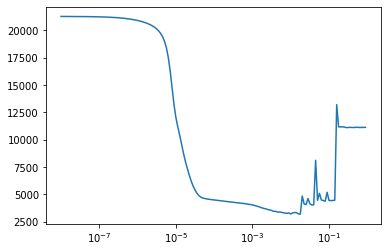

In [52]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
123/123 [==============================] - 3s 27ms/step - loss: 11381.0086 - mae: 57.6197 - val_loss: 4269.9265 - val_mae: 31.2928
Epoch 2/500
123/123 [==============================] - 2s 19ms/step - loss: 4899.4642 - mae: 32.7033 - val_loss: 3501.6651 - val_mae: 26.3855
Epoch 3/500
123/123 [==============================] - 2s 19ms/step - loss: 4550.0259 - mae: 30.6579 - val_loss: 3475.0146 - val_mae: 26.2166
Epoch 4/500
123/123 [==============================] - 2s 20ms/step - loss: 4493.2085 - mae: 30.3664 - val_loss: 3419.8516 - val_mae: 26.1797
Epoch 5/500
123/123 [==============================] - 2s 19ms/step - loss: 4449.2420 - mae: 30.1895 - val_loss: 3391.0609 - val_mae: 25.8473
Epoch 6/500
123/123 [==============================] - 2s 20ms/step - loss: 4408.0733 - mae: 30.0752 - val_loss: 3393.4032 - val_mae: 25.9072
Epoch 7/500
123/123 [==============================] - 2s 19ms/step - loss: 4370.6945 - mae: 30.0626 - val_loss: 3362.7485 - val_mae: 25.8944
Epoch

In [54]:
model = keras.models.load_model("my_checkpoint.h5")

In [55]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

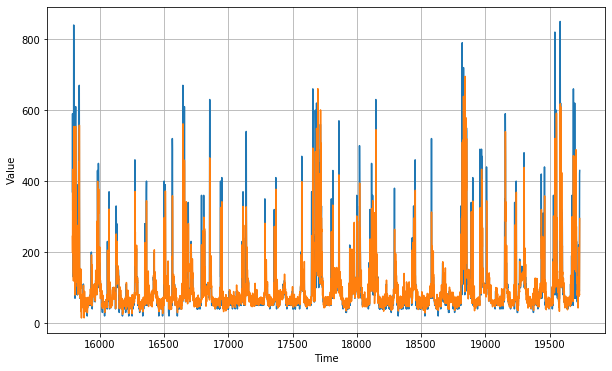

In [56]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [57]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

27.603807

In [58]:
keras.metrics.mean_squared_error(x_valid, cnn_forecast).numpy()

3457.8506